# Simulation of Vessel Trajectories & Anomalies

**TODOs**

- [ ] Get start orientation of vessels from port?
- [ ] Get speed based on route? 
- [x] Save simulated trajectories to file
- [ ] Add anomalies
    - [ ] Add speed anomalies
        - [x] Basic speed anomalies 
    - [ ] Add location anomalies 
        - [x] Basic location anomalies (i.e. designate all records in an area as anomalous)
        - [ ] Advanced location anomalies (i.e. vessels ignore obstacles)
    - [ ] Add direction anomalies? 
- [ ] Create export for M³ training, incl. MMSI, T, LAT, LON, SOG, COG, vessel type? 

In [184]:
import pandas as pd
import movingpandas as mpd
from datetime import datetime, timedelta

from model import ShipModel

MAX_STEPS = 1000
N_SHIPS = 20

ports = [(11,10), (30,30),(70,50),(10,70),(70,20), (90,89)]
obstacles = [(99,99),(10,0),(6,60),(45,24),(20,18),(20,16),(20,14),(40,15),(60,40),
             (60,42),(60,44),(61,46),(62,48),(63,50),(64,52),(63,58),(62,60),(62,62),(61,64),
             (60,83),(60,85),
             (69,30),(71,29),(73,28),(75,27)]
model = ShipModel(population=N_SHIPS, vision=20, ports=ports, obstacles=obstacles)

for type, agents in model.agents_by_type.items():
    print(f'{type}: {len(agents)}')


Setting starting port to [70 50] ...
Setting destination port to (11, 10) ...
Setting max speed to 1.2498513306089956 ...
Setting starting port to [90 89] ...
Setting destination port to (70, 50) ...
Setting max speed to 1.3088735861023937 ...
Setting starting port to [10 70] ...
Setting destination port to (30, 30) ...
Setting max speed to 1.2565123095368993 ...
Setting starting port to [70 20] ...
Setting destination port to (11, 10) ...
Setting max speed to 1.0588087580685517 ...
Setting starting port to [30 30] ...
Setting destination port to (70, 50) ...
Setting max speed to 1.100995089008664 ...
Setting starting port to [10 70] ...
Setting destination port to (70, 50) ...
Setting max speed to 1.421285760580007 ...
Setting starting port to [11 10] ...
Setting destination port to (90, 89) ...
Setting max speed to 1.0585444545101725 ...
Setting starting port to [10 70] ...
Setting destination port to (30, 30) ...
Setting max speed to 1.4541881701530388 ...
Setting starting port to [

## Trajectory Simulation

In [185]:
print(f"{datetime.now()} Starting ...")
for t in range(MAX_STEPS):
    stride = 50
    if t%stride == 0:
        print(f"Steps {t} - {t+stride-1}...")
    model.step()
print(f"{datetime.now()} Finished.")

2025-02-21 09:56:48.696005 Starting ...
Steps 0 - 49...
Steps 50 - 99...
Steps 100 - 149...
Steps 150 - 199...
Steps 200 - 249...
Steps 250 - 299...
Steps 300 - 349...
Steps 350 - 399...
Steps 400 - 449...
Steps 450 - 499...
Steps 500 - 549...
Steps 550 - 599...
Steps 600 - 649...
Steps 650 - 699...
Steps 700 - 749...
Steps 750 - 799...
Steps 800 - 849...
Steps 850 - 899...
Steps 900 - 949...
Steps 950 - 999...
2025-02-21 11:10:37.814292 Finished.


2 vessels x 1000 steps ... 7 min

20 vessels x 1000 steps ... > 1h


In [186]:
agent_df = model.datacollector.get_agent_vars_dataframe()

In [187]:
df = agent_df.reset_index()
df[['x', 'y']] = pd.DataFrame(df['pos'].tolist(), index=df.index)
df = df.drop(columns=['pos'])
df = df[df.AgentID<=N_SHIPS] # removes obstacles
df

,Step,AgentID,x,y
0,0,1,70.000000,50.000000
1,0,2,90.000000,89.000000
2,0,3,10.000000,70.000000
3,0,4,70.000000,20.000000
4,0,5,30.000000,30.000000
...,...,...,...,...
45015,1000,16,69.954390,20.027525
45016,1000,17,9.984810,69.969980
45017,1000,18,11.032748,9.972244
45018,1000,19,69.954447,49.995908


In [188]:
start_datetime = datetime.now()
df["t"] = df["Step"].apply(lambda step: start_datetime + timedelta(seconds=step))

In [189]:
tc = mpd.TrajectoryCollection(df, traj_id_col='AgentID', t='t', x='x', y='y', crs=31287)

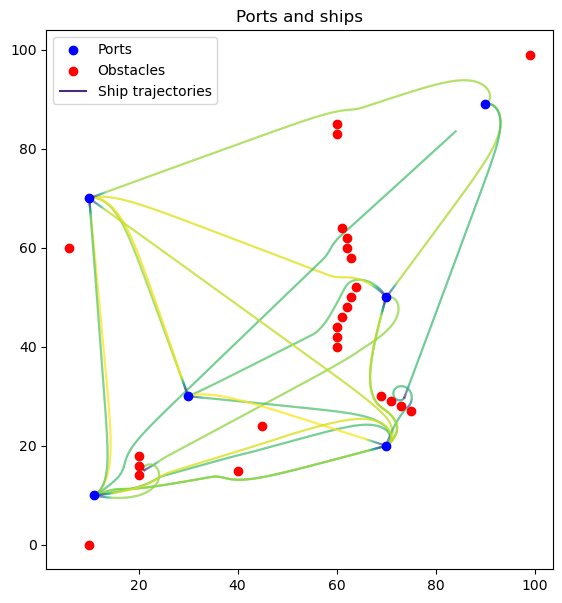

In [190]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,7))

x_coords, y_coords = zip(*ports)
ax.scatter(x_coords, y_coords, color='blue', label='Ports', zorder=5)
x_coords, y_coords = zip(*obstacles)
ax.scatter(x_coords, y_coords, color='red', label='Obstacles', zorder=5)
tc.plot(ax=ax, label='Ship trajectories', column='speed')

# Labels and legend
ax.legend()
ax.set_title("Ports and ships")

plt.show()

In [191]:
tc.trajectories[1].hvplot()

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (triangle_angle)

In [192]:
tc.add_speed(overwrite=True)
tc.trajectories[0].df#.hvplot(c='speed')

,Step,AgentID,geometry,speed
t,,,,
2025-02-21 11:10:38.002282,0,1,POINT (70 50),0.019
2025-02-21 11:10:39.002282,1,1,POINT (70.018 50.007),0.019
2025-02-21 11:10:40.002282,2,1,POINT (70.045 50.018),0.029
2025-02-21 11:10:41.002282,3,1,POINT (70.08 50.031),0.038
2025-02-21 11:10:42.002282,4,1,POINT (70.125 50.046),0.047
...,...,...,...,...
2025-02-21 11:27:14.002282,996,1,POINT (11.033 9.993),0.001
2025-02-21 11:27:15.002282,997,1,POINT (11.032 9.993),0.001
2025-02-21 11:27:16.002282,998,1,POINT (11.031 9.993),0.001


In [193]:
sim_result = tc.to_point_gdf()
sim_result['x'] = sim_result.geometry.x
sim_result['y'] = sim_result.geometry.y
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
sim_out_file_name = f'sim_{timestamp}.csv'
sim_result.to_csv(sim_out_file_name)
print(f'Saved simulation results to {sim_out_file_name}')

Saved simulation results to sim_20250221_111045.csv


## Anomaly Simulation

In [194]:
import numpy as np
import pandas as pd
import movingpandas as mpd
from datetime import datetime, timedelta

In [195]:
#sim_out_file_name = 'sim_20250220_183448.csv'

In [196]:
sims = pd.read_csv(sim_out_file_name)
sims['is_anomaly'] = False
sims['anomaly_type'] = 'n/a'
tc = mpd.TrajectoryCollection(sims, t='t', traj_id_col='AgentID', x='x', y='y', crs=31287)
tc

TrajectoryCollection with 20 trajectories

In [197]:
# Remove stopped segments (with speed < 0.01)
tc = mpd.SpeedSplitter(tc).split(speed=0.01, duration=timedelta(seconds=5))
    

### Speed

* Change the timestamps to make a subsection of the trajectory faster

In [198]:
def inject_speed_anomaly(traj, duration_pct=(0.1,0.2), speedup_pct=(1.5,2.5)):
    df = traj.df.copy()
    df.reset_index(inplace=True)
    df["t_diff"] = df['t'].diff()
    # Choose within middle range
    total_steps = len(df)
    anomaly_start_idx = np.random.randint(0.1 * total_steps, 0.8 * total_steps)  
    duration_pct = duration_pct[0] + (np.random.random() * (duration_pct[1]-duration_pct[0]))
    anomaly_duration = int(duration_pct * total_steps)  
    # Insert new values
    speedup_pct = speedup_pct[0] + (np.random.random() * (speedup_pct[1]-speedup_pct[0]))
    new_vals = df.iloc[anomaly_start_idx : anomaly_start_idx + anomaly_duration].t_diff / speedup_pct
    df.loc[anomaly_start_idx : anomaly_start_idx + anomaly_duration -1, "t_diff"] = new_vals
    # Flag anomalies
    df.loc[anomaly_start_idx : anomaly_start_idx + anomaly_duration -1, "is_anomaly"] = True
    df.loc[anomaly_start_idx : anomaly_start_idx + anomaly_duration -1, "anomaly_type"] = 'speed'

    # Correct the timestamp update logic
    df["t"] = df["t"].iloc[0] + df["t_diff"].fillna(pd.Timedelta(seconds=0)).cumsum()
    return mpd.Trajectory(df,t='t',traj_id=traj.id)


<Axes: >

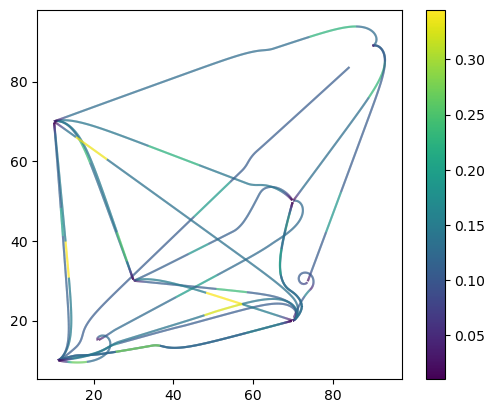

In [199]:
for i, traj in enumerate(tc.trajectories):
    traj = inject_speed_anomaly(traj)
    tc.trajectories[i] = traj
    
tc.add_speed(overwrite=True)
tc.plot(column='speed', legend=True)

### Location

Select all trajectories that go through a certain area and mark them anomalous

<Axes: >

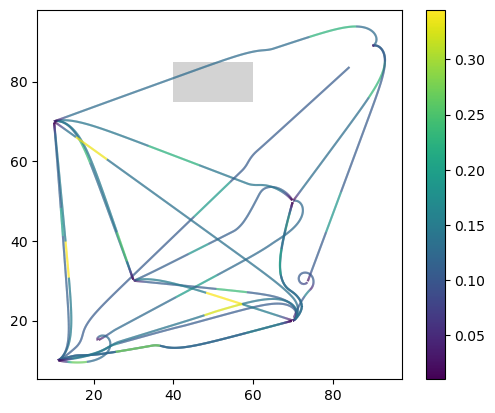

In [200]:
from shapely.geometry import Polygon
from geopandas import GeoSeries
xmin, xmax, ymin, ymax = 40, 60, 75, 85
polygon = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)])

ax= tc.plot(column='speed', legend=True)
GeoSeries(polygon).plot(ax=ax, color="lightgray")

In [201]:
def inject_location_anomaly(traj, polygon):
    df = traj.df.copy()
    intersecting = df.intersects(polygon)
    df.loc[intersecting, 'is_anomaly'] = True
    df.loc[intersecting, 'anomaly_type'] = 'location'
    return mpd.Trajectory(df,t='t',traj_id=traj.id)

In [202]:
for i, traj in enumerate(tc.trajectories):
    traj = inject_location_anomaly(traj, polygon)
    tc.trajectories[i] = traj
    

<Axes: >

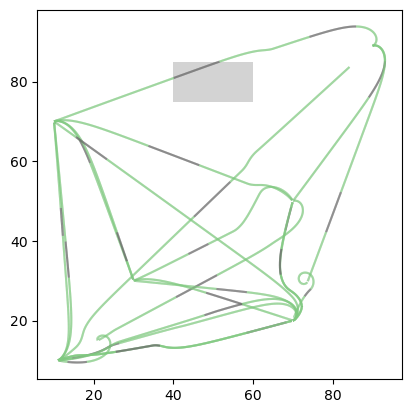

In [203]:
ax = tc.plot(column='is_anomaly', cmap='Accent')
GeoSeries(polygon).plot(ax=ax, color="lightgray")

### Direction

* Pick an OD combination that will be marked as anomalous in one direction

In [183]:
tc.to_point_gdf()

,Step,AgentID,geometry,speed,is_anomaly,anomaly_type,t_diff,traj_id
t,,,,,,,,
2025-02-20 19:10:38.089788000,0,1_0,POINT (30 30),0.019,False,n/a,NaT,1_0
2025-02-20 19:10:39.089788000,1,1_0,POINT (30.018 30.007),0.019,False,n/a,0 days 00:00:01,1_0
2025-02-20 19:10:40.089788000,2,1_0,POINT (30.044 30.019),0.029,False,n/a,0 days 00:00:01,1_0
2025-02-20 19:10:41.089788000,3,1_0,POINT (30.079 30.035),0.038,False,n/a,0 days 00:00:01,1_0
2025-02-20 19:10:42.089788000,4,1_0,POINT (30.121 30.056),0.047,False,n/a,0 days 00:00:01,1_0
...,...,...,...,...,...,...,...,...
2025-02-20 19:14:51.896113274,281,10_0,POINT (29.72 29.784),0.011,False,n/a,0 days 00:00:01,10_0
2025-02-20 19:14:52.896113274,282,10_0,POINT (29.728 29.791),0.011,False,n/a,0 days 00:00:01,10_0
2025-02-20 19:14:53.896113274,283,10_0,POINT (29.737 29.798),0.011,False,n/a,0 days 00:00:01,10_0


## Export for M³ / M³fed